# Import required packages

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from zipfile import ZipFile
import os

# Read data from CSV

In [5]:
with ZipFile('../dataset/creditcard.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [6]:
cred_data = pd.read_csv('creditcard.csv')

# Exploring dataset

In [7]:
# check columns
print(cred_data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [58]:
# check shape
cred_data.shape

(284807, 31)

In [59]:
# check null
cred_data.isnull().sum().max()

0

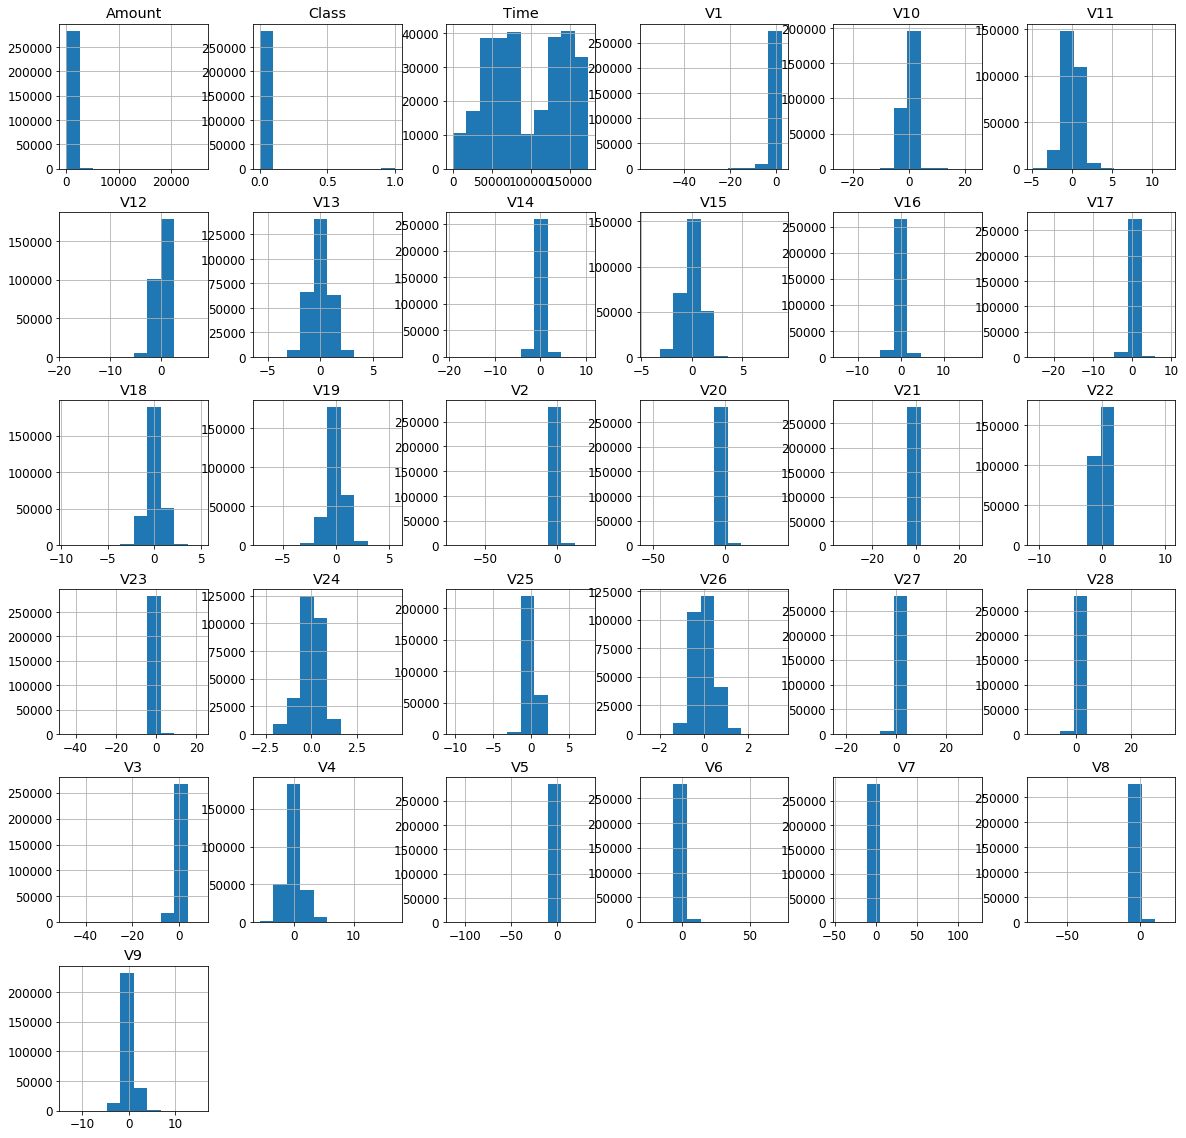

In [60]:
# plot the histogram of each parameter

cred_data.hist(figsize = (20, 20))
plt.show()

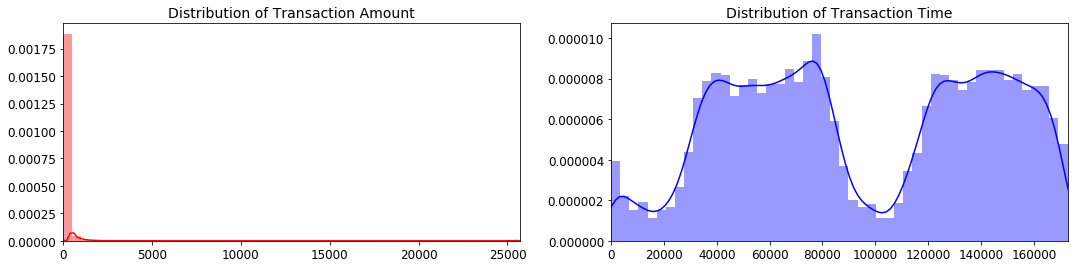

In [61]:
# plot graphs for amount and time

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = cred_data['Amount'].values
time_val = cred_data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

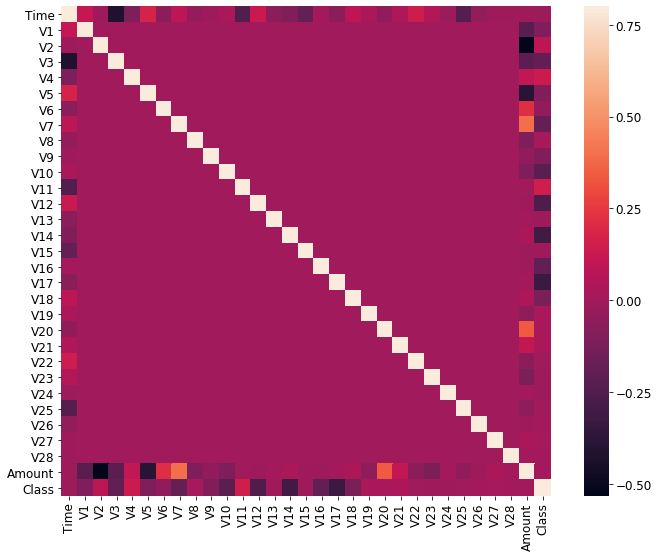

In [62]:
# correlation matrix
corrmat = cred_data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [63]:
# determine the number of fraud cases
fraud = cred_data[cred_data['Class'] == 1]
valid = cred_data[cred_data['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.0017304750013189597
Fraud Cases: 492
Valid Cases: 284315


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

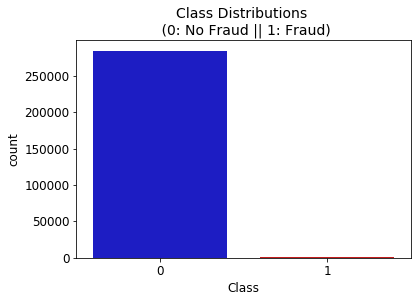

In [64]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=cred_data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

# Scaling and distribution

In [65]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# Using RobustScaler as it is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

cred_data['scaled_amount'] = rob_scaler.fit_transform(cred_data['Amount'].values.reshape(-1,1))
cred_data['scaled_time'] = rob_scaler.fit_transform(cred_data['Time'].values.reshape(-1,1))

cred_data.drop(['Time','Amount'], axis=1, inplace=True)

In [13]:
scaled_amount = cred_data['scaled_amount']
scaled_time = cred_data['scaled_time']

cred_data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
cred_data.insert(0, 'scaled_amount', scaled_amount)
cred_data.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

cred_data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Splitting the Data

In [66]:
X = cred_data.drop('Class', axis=1)
y = cred_data['Class']
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, stratify=y, test_size=0.3)

In [67]:
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

In [68]:
# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.99827451 0.00172549]
[0.99826785 0.00173215]


# Handling imbalance dataset

### a) SMOTE

In [69]:


print("Before OverSampling, counts of label '1': {}".format(sum(original_ytrain==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(original_ytrain==0)))

sm = SMOTE(random_state=2)
X_train_sm, y_train_sm = sm.fit_sample(original_Xtrain, original_ytrain.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_sm==0)))

Before OverSampling, counts of label '1': 344
Before OverSampling, counts of label '0': 199020 

After OverSampling, the shape of train_X: (398040, 30)
After OverSampling, the shape of train_y: (398040,) 

After OverSampling, counts of label '1': 199020
After OverSampling, counts of label '0': 199020


### b) ADASYN

In [70]:


print("Before OverSampling, counts of label '1': {}".format(sum(original_ytrain==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(original_ytrain==0)))

ada = ADASYN(random_state = 2)

X_train_ada, y_train_ada = ada.fit_sample(original_Xtrain, original_ytrain.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_ada.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_ada.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_ada==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_ada==0)))

Before OverSampling, counts of label '1': 344
Before OverSampling, counts of label '0': 199020 

After OverSampling, the shape of train_X: (398033, 30)
After OverSampling, the shape of train_y: (398033,) 

After OverSampling, counts of label '1': 199013
After OverSampling, counts of label '0': 199020


# Model implementation

### a) Logistic Regression Model

##### Logistic regression on SMOTE data with best hyperparameters

In [23]:
# define models to get best hyperparameters
lg_model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lg_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_sm, y_train_sm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.999195 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999195 (0.000136) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999195 (0.000136) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.999195 (0.000136) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.999195 (0.000136) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999195 (0.000136) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.999195 (0.000136) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.999195 (0.000135) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999195 (0.000135) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.999192 (0.000133) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.999184 (0.000138) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999184 (0.000138) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.999181 (0.000133) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.999156 (0.000128) wit

In [19]:
# Assigned best hyperparameters value

log_reg_params = {"solver": ['newton-cg'],
                  "penalty": ['l2'], 
                  'C':  [100],
                 "max_iter" : [1000]}

In [49]:
#Build model
lg_model = LogisticRegression()

# define grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lg_model, param_grid=log_reg_params, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_sm, y_train_sm)



In [52]:
y_pred = grid_result.predict(original_Xtest)
y_pred_proba = grid_result.predict_proba(original_Xtest)[:, 1]

Accuracy :0.97143
AUC : 0.94185
Precision : 0.05267
Recall : 0.91216
F1 : 0.09959
AUC -  0.9418481248702832 



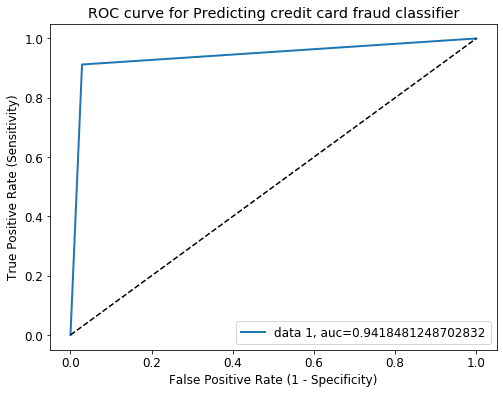

In [53]:
# Check results

print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(original_ytest , y_pred)))


# plot ROC Curve

plt.figure(figsize=(8,6))

[fpr, tpr, thr] = metrics.roc_curve(original_ytest, y_pred)

auc = metrics.roc_auc_score(original_ytest, y_pred)

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting credit card fraud classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

##### Logistic regression on ADASYN with best hyperparameters

In [14]:
# define models to get best hyperparameters
lg_model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lg_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_ada, y_train_ada)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.866407 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.866407 (0.002533) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.866399 (0.002540) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.866395 (0.002540) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.866399 (0.002532) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.866389 (0.002537) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.866387 (0.002533) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.866355 (0.002539) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.866333 (0.002547) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.866345 (0.002546) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.865779 (0.002587) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.865757 (0.002586) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.865727 (0.002595) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.862740 (0.002692) wit

In [42]:
# Assigned best hyperparameters value

log_reg_params = {"solver": ['newton-cg'],
                  "penalty": ['l2'], 
                  'C':  [100],
                 "max_iter" : [1000]}

In [66]:
#Build model
lg_model = LogisticRegression()

# define grid search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lg_model, param_grid=log_reg_params, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_ada, y_train_ada)



In [67]:
y_pred = grid_result.predict(original_Xtest)
y_pred_proba = grid_result.predict_proba(original_Xtest)[:, 1]

Accuracy :0.91771
AUC : 0.91831
Precision : 0.01901
Recall : 0.91892
F1 : 0.03724
AUC -  0.9183140230329397 



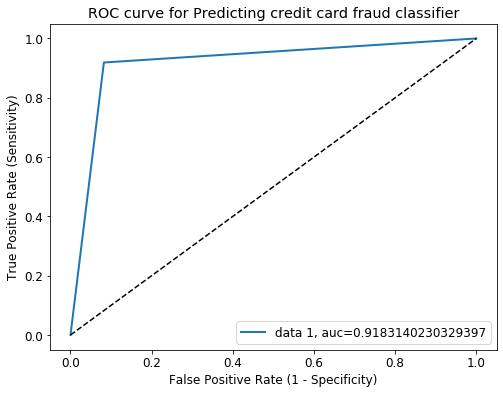

In [68]:
# Check results

print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(original_ytest , y_pred)))


# plot ROC Curve

plt.figure(figsize=(8,6))

[fpr, tpr, thr] = metrics.roc_curve(original_ytest, y_pred)

auc = metrics.roc_auc_score(original_ytest, y_pred)


plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting credit card fraud classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

### b) Random Forest Model

##### Random forest on SMOTE data with best hyperparameters

In [40]:
#Build model to find best hyperparameters

rf_model = RandomForestClassifier()
n_estimators = [10, 50]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_sm, y_train_sm)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.999995 using {'max_features': 'log2', 'n_estimators': 50}
0.999973 (0.000040) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.999995 (0.000020) with: {'max_features': 'sqrt', 'n_estimators': 50}
0.999977 (0.000038) with: {'max_features': 'log2', 'n_estimators': 10}
0.999995 (0.000015) with: {'max_features': 'log2', 'n_estimators': 50}


In [28]:
# Assigned best hyperparameters value

rf_params = {'max_features': ['log2'],
             'n_estimators': [50]
            }

In [29]:
# build model

rf_model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_params, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_sm, y_train_sm)

In [30]:
y_pred = grid_result.predict(original_Xtest)
y_pred_proba = grid_result.predict_proba(original_Xtest)[:, 1]

Accuracy :0.99945
AUC : 0.90529
Precision : 0.86331
Recall : 0.81081
F1 : 0.83624
AUC -  0.9052940272472485 



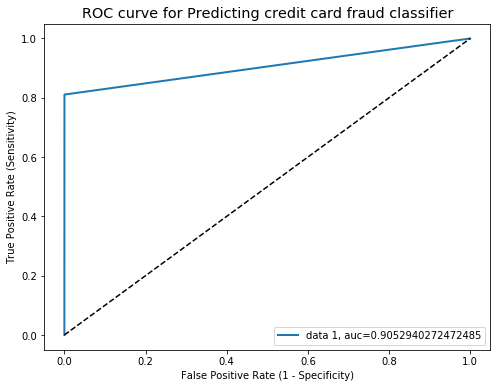

In [31]:
# Check results

print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(original_ytest , y_pred)))


# plot ROC Curve

plt.figure(figsize=(8,6))

[fpr, tpr, thr] = metrics.roc_curve(original_ytest, y_pred)

auc = metrics.roc_auc_score(original_ytest, y_pred)


plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting credit card fraud classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

##### Random forest on ADASYN with best hyperparameters

In [71]:
#Build model to find best hyperparameters

rf_model = RandomForestClassifier()
n_estimators = [10, 50]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_ada, y_train_ada)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.999998 using {'max_features': 'log2', 'n_estimators': 50}
0.999987 (0.000026) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.999995 (0.000020) with: {'max_features': 'sqrt', 'n_estimators': 50}
0.999990 (0.000020) with: {'max_features': 'log2', 'n_estimators': 10}
0.999998 (0.000009) with: {'max_features': 'log2', 'n_estimators': 50}


In [72]:
# Assigned best hyperparameters value

rf_params = {'max_features': ['log2'],
             'n_estimators': [50]
            }

In [73]:
# build model

rf_model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_params, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train_ada, y_train_ada)

In [74]:
y_pred = grid_result.predict(original_Xtest)
y_pred_proba = grid_result.predict_proba(original_Xtest)[:, 1]

Accuracy :0.99939
AUC : 0.88166
Precision : 0.86923
Recall : 0.76351
F1 : 0.81295


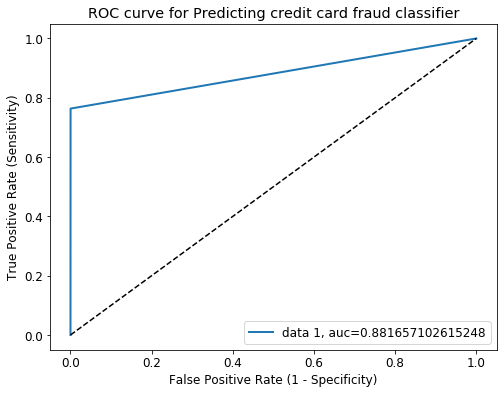

In [75]:
# Check results

print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(original_ytest , y_pred)))


# plot ROC Curve

plt.figure(figsize=(8,6))

[fpr, tpr, thr] = metrics.roc_curve(original_ytest, y_pred)

auc = metrics.roc_auc_score(original_ytest, y_pred)

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting credit card fraud classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

### c) XGBoost Model

##### XGBoost on SMOTE data with best hyperparameters

In [84]:
# Range
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [85]:
# Find best hyperparameters

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train_sm, y_train_sm), (original_Xtest, original_ytest)]
    
    clf.fit(X_train_sm, y_train_sm,
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(original_Xtest)
    accuracy = accuracy_score(original_ytest, pred>0.95)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [25]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.9878281427384338                                                                                                     
SCORE:                                                                                                                 
0.9906838477113398                                                                                                     
SCORE:                                                                                                                 
0.9907540699647719                                                                                                     
SCORE:                                                                                                                 
0.9886825134885245                                                                                                     
SCORE:                                  

SCORE:                                                                                                                 
0.990426366115422                                                                                                      
SCORE:                                                                                                                 
0.9906370328757184                                                                                                     
SCORE:                                                                                                                 
0.988167550296689                                                                                                      
SCORE:                                                                                                                 
0.9907657736736772                                                                                                     
SCORE:                                  

In [26]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.946577415818191, 'gamma': 1.6699298032138379, 'max_depth': 10.0, 'min_child_weight': 0.0, 'reg_alpha': 41.0, 'reg_lambda': 0.8427774450953076}


In [30]:
#Build model using best hyperparameters value

from sklearn import metrics

xgb_model=xgb.XGBClassifier(max_depth= 10,
        gamma= 1.6699298032138379,
        reg_alpha = 41,
        reg_lambda = 0.8427774450953076,
        colsample_bytree = 0.946577415818191,
        min_child_weight = 0,
        n_estimators= 180,
        seed= 0)
    
evaluation = [(X_train_sm, y_train_sm), (original_Xtest, original_ytest)]
    
xgb_model.fit(X_train_sm, y_train_sm,eval_set=evaluation, eval_metric="aucpr",early_stopping_rounds=10,verbose=False)
    
y_pred = xgb_model.predict(original_Xtest)

y_pred_proba = xgb_model.predict_proba(original_Xtest)[:, 1]

Accuracy :0.99816
AUC : 0.92826
Precision : 0.48289
Recall : 0.85811
F1 : 0.61800
AUC -  0.928256820921983 



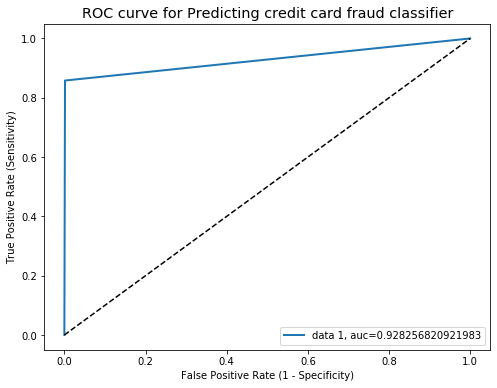

In [31]:
# Check results

print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(original_ytest , y_pred)))


# plot ROC Curve

plt.figure(figsize=(8,6))

[fpr, tpr, thr] = metrics.roc_curve(original_ytest, y_pred)

auc = metrics.roc_auc_score(original_ytest, y_pred)
print("AUC - ",auc,"\n")

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting credit card fraud classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

##### XGBoost on ADASYN data with best hyperparameters

In [47]:
# Range
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [48]:
# Find best hyperparameters

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train_ada, y_train_ada), (original_Xtest, original_ytest)]
    
    clf.fit(X_train_ada, y_train_ada,
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(original_Xtest)
    accuracy = accuracy_score(original_ytest, pred>0.95)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [49]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.9559355359713493                                     
SCORE:                                                                            
0.9554205727795139                                                                
SCORE:                                                                            
0.9584635370949054                                                                
SCORE:                                                                            
0.9543204241424107                                                                
SCORE:                                                                            
0.9520382009058671                                                                
SCORE:                                                                            
0.9572814624954649                                                                
SCORE:                                                    

SCORE:                                                                             
0.9584401296770947                                                                 
SCORE:                                                                             
0.9601722785950868                                                                 
100%|██████████| 100/100 [27:45<00:00, 17.58s/trial, best loss: -0.9661177627190056]


In [51]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5459870498322141, 'gamma': 4.223462286581759, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 68.0, 'reg_lambda': 0.1419700272423003}


In [52]:
#Build model using best hyperparameters value
xgb_model=xgb.XGBClassifier(max_depth= 7,
        gamma= 4.223462286581759,
        reg_alpha = 68,
        reg_lambda = 0.1419700272423003,
        colsample_bytree = 0.5459870498322141,
        min_child_weight = 6,
        n_estimators= 180,
        seed= 0)
    
evaluation = [(X_train_ada, y_train_ada), (original_Xtest, original_ytest)]
    
xgb_model.fit(X_train_ada, y_train_ada,eval_set=evaluation, eval_metric="aucpr",early_stopping_rounds=10,verbose=False)
    
y_pred = xgb_model.predict(original_Xtest)

y_pred_proba = xgb_model.predict_proba(original_Xtest)[:, 1]

Accuracy :0.99669
AUC : 0.91066
Precision : 0.32190
Recall : 0.82432
F1 : 0.46300
AUC -  0.9106556260228809 



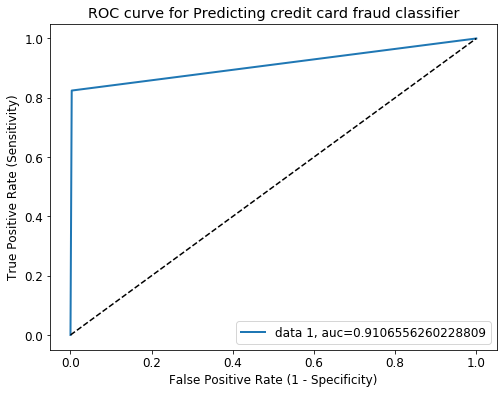

In [53]:
# Check results

print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_pred , original_ytest))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(original_ytest , y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(original_ytest , y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(original_ytest , y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(original_ytest , y_pred)))


# plot ROC Curve

plt.figure(figsize=(8,6))

[fpr, tpr, thr] = metrics.roc_curve(original_ytest, y_pred)

auc = metrics.roc_auc_score(original_ytest, y_pred)

plt.plot(fpr,tpr,linewidth=2, label="data 1, auc="+str(auc))
plt.legend(loc=4)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting credit card fraud classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

# Result

##### Logistic Regression on SMOTE 
    Accuracy :0.97143
    AUC : 0.94185
    Recall : 0.91216
##### Logistic Regression on ADASYN 
    Accuracy :0.91771
    AUC : 0.91831
    Recall : 0.91892
##### Random Forest on SMOTE 
    Accuracy :0.99945
    AUC : 0.90529
    Recall : 0.81081
##### Random Forest  on ADASYN 
    Accuracy :0.99939
    AUC : 0.88166
    Recall : 0.76351
##### XGBoost on SMOTE 
    Accuracy :0.99816
    AUC : 0.92826
    Recall : 0.85811
##### XGBoost on ADASYN 
    Accuracy :0.99669
    AUC : 0.91066
    Recall : 0.82432

##### After seeing the results of Logistic Regression, Random Forest and XGBoost on balanced data using SMOTE and ADASYN techniques, we will go ahead with Logistic Regression using SMOTE balancing techniques as it has better recall and auc, and decent accuracy with respect to other mod.

In [9]:
if os.path.exists("creditcard.csv"):
    os.remove("creditcard.csv")